In [1]:
from pathlib import Path
import numpy as np
import sys
import importlib

In [2]:
working_dir = Path('../input_files/magshockz-v3.0.2d')
input_file = working_dir / 'magshockz-v3.0.1d'

py_script = working_dir / 'py-script-1d.py'



def read_sim_bounds(input_file: Path):
    xmin, xmax = None, None

    def search_line(line: str, splitter: str):
        return line.split(splitter)[1].split(',')[0].strip()

    with input_file.open() as f:
        for line in f:
            line = line.lstrip()
            if line.startswith("xmax"):
                xmax = float(search_line(line, "="))
            elif line.startswith("xmin"):
                xmin = float(search_line(line, "="))

    if xmin is None or xmax is None:
        raise ValueError("xmin or xmax not found in the input file")
    return xmax-xmin

sys.path.append(working_dir.as_posix())
pyt = importlib.import_module(py_script.stem)

d = read_sim_bounds(input_file)

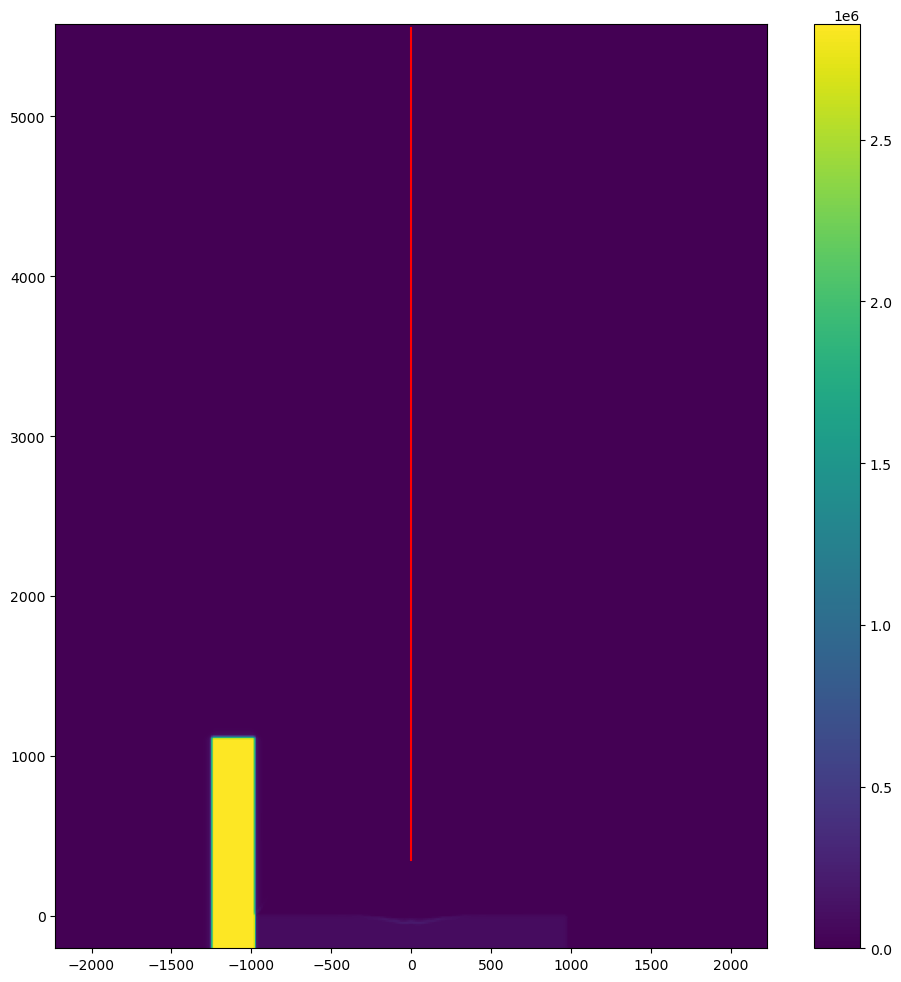

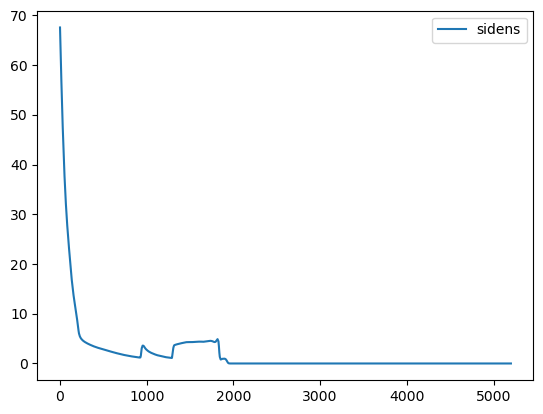

In [3]:
import matplotlib.pyplot as plt


field = 'sidens.npy'
pyt.theta = np.pi/2

def plot_line_on_density(field):
    if field.endswith('.npy'):
        data = np.load(working_dir / 'interp' / field)

    elif field.endswith('.pkl'):
        import pickle
        with open(working_dir/ 'interp'/ field, "rb") as p:
            f = pickle.load(p)
            x = np.linspace(pyt.box_bounds['xmin']+8, pyt.box_bounds['xmax']-8, 1000)
            y = np.linspace(pyt.box_bounds['ymin']+8, pyt.box_bounds['ymax']-8, 1000)
            x1,x2 = np.meshgrid(y,x)
        data = f((x1,x2))

    plt.figure(figsize=(12,12))

    plt.imshow(data.T, origin='lower',
           extent=[pyt.box_bounds['xmin'], pyt.box_bounds['xmax'], pyt.box_bounds['ymin'], pyt.box_bounds['ymax']])
    plt.colorbar()

    plt.plot([pyt.start_point[0], pyt.start_point[0]+d*np.cos(pyt.theta)], [pyt.start_point[1],pyt.start_point[1]+d*np.sin(pyt.theta)],color='r')
    plt.show()
    return

plot_line_on_density(field = field)

def make_1d_plot(field):
    from scipy.interpolate import RegularGridInterpolator

    x_osiris = np.linspace(pyt.start_point[0], pyt.start_point[0] + d*np.cos(pyt.theta),1000)
    y_osiris = np.linspace(pyt.start_point[1], pyt.start_point[1] + d*np.sin(pyt.theta),1000)

    if field.endswith('.npy'):
        data = np.load(working_dir / 'interp' / field)

        x = np.linspace(pyt.box_bounds['xmin'], pyt.box_bounds['xmax'], data.shape[0])
        y = np.linspace(pyt.box_bounds['ymin'], pyt.box_bounds['ymax'], data.shape[1])
        f = RegularGridInterpolator((x, y), np.load(working_dir / 'interp' / field))
        plt.plot(np.linspace(0, d, 1000), f((x_osiris,y_osiris)), label=f"{field.strip('.npy')}")

    elif field.endswith('.pkl'):
        import pickle
        with open(working_dir/ 'interp'/ field, "rb") as p:
            f = pickle.load(p)
            plt.plot(np.linspace(0, d, 1000), f((y_osiris,x_osiris)), label=f"{field.strip('.pkl')}")
    
    plt.legend()
    return

make_1d_plot(field = field)
# make_1d_plot(field = 'magx.pkl')
# make_1d_plot(field = 'magy.pkl')
# make_1d_plot(field = 'magz.pkl')